# Age prediction


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import umap
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot

/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/.tsetse_mirs/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [11]:
colors = sn.color_palette("Set2") 

In [12]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldataset.dat", sep='\t')
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [13]:
tsetse_data_copy = tsetse_data.copy()

In [14]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF = tsetse_data_copy[dList]

In [9]:
tsetse_males_thorax = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data_copy.loc[(descriptorsDF['Sex'] == 'm') & (descriptorsDF['Tissue'] == 'Head')]

In [15]:
tsetse_males_thorax.groupby("Age")["ID"].count()

Age
5w    93
7w    92
Name: ID, dtype: int64

In [16]:
tsetse_males_head.groupby("Age")["ID"].count()

Age
5w    94
7w    93
Name: ID, dtype: int64

In [17]:
tsetse_males_thorax_copy = tsetse_males_thorax.copy()
tsetse_males_head_copy = tsetse_males_head.copy()

In [18]:
dList=['Plate','Sex', 'Age', 'ID.1', 'Tissue','ID']
descriptorsDF_thorax = tsetse_males_thorax[dList]
tsetse_males_thorax_copy.drop(dList, axis=1,inplace=True)


descriptorsDF_head = tsetse_males_head_copy[dList]
tsetse_males_head_copy.drop(dList, axis=1,inplace=True)

In [19]:
waveNumslist = tsetse_males_thorax_copy.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [20]:
y_labels_head = descriptorsDF_head['Age']
y_labels_thorax = descriptorsDF_thorax['Age']

## Clustering

In [21]:
# males head
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_males_head_copy)
embedding_head = reducer.fit_transform(features_scaled)

In [22]:
# Females thorax
reducer = umap.UMAP(n_neighbors = 30, transform_seed=123, min_dist=0.0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(tsetse_males_thorax_copy)
embedding_thorax= reducer.fit_transform(features_scaled)

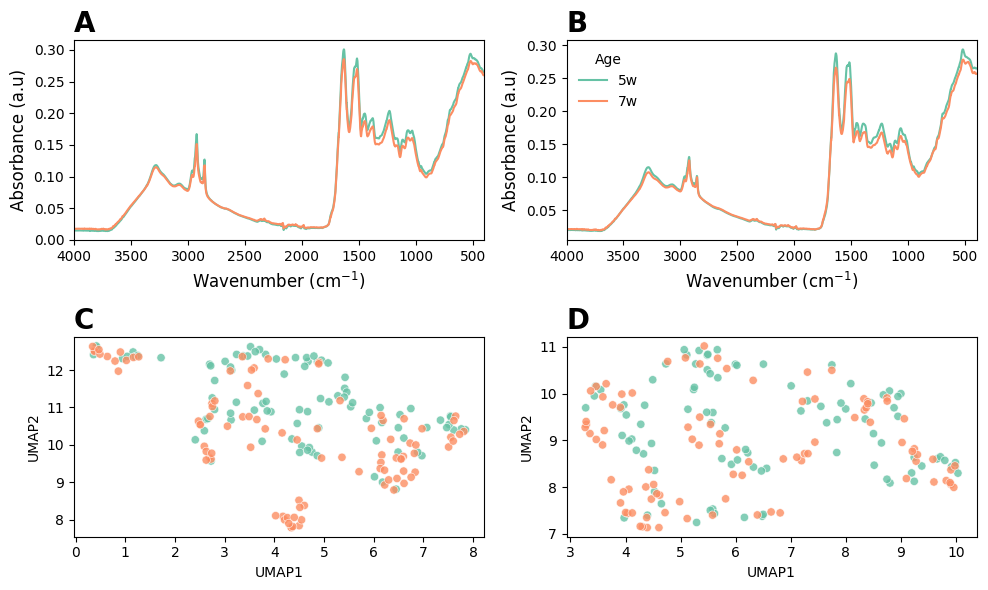

In [23]:
sn.set_palette("Set2")

fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,6))

# head
sn.scatterplot(x=embedding_head[:,0], y=embedding_head[:,1], alpha=0.8, hue=descriptorsDF_head['Age'],ax=ax3, legend=False)
ax3.set_xlabel("UMAP1")
ax3.set_ylabel("UMAP2")

# thorax
sn.scatterplot(x=embedding_thorax[:,0], y=embedding_thorax[:,1], alpha=0.8, hue=descriptorsDF_thorax['Age'],legend=False,ax=ax4)
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")
#ax3.legend( bbox_to_anchor=(0.5, 0.05, 0.3, 0.1),ncols=3,frameon=False)



# head
for i, c in zip(np.unique(y_labels_head), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_head_copy[y_labels_head == i], axis=0), label=i, color=c, ax=ax)
ax.get_legend().remove()
ax.set_xlim(4000,401)
ax.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax.set_ylabel("Absorbance (a.u)",fontsize=12)

# thorax
for i, c in zip(np.unique(y_labels_thorax), colors):
    sn.lineplot(x=wavenumbers, y=np.mean(tsetse_males_thorax_copy[y_labels_thorax == i], axis=0), label=i, color=c,ax=ax2)
ax2.set_xlim(4000,401)
ax2.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize=12)
ax2.set_ylabel("Absorbance (a.u)",fontsize=12)
ax2.legend(title="Age",frameon=False)


labeles = ["A", "B", "C", "D", "E", "F"]
axes = fig.get_axes()
for a, l in zip(axes, labeles):
    a.set_title(l, loc='left', fontsize=20, fontweight='bold')



plt.tight_layout()
plt.savefig("../results/plots/UMAP_Spectra_age_males.png", dpi=300)

## Age prediction males

In [24]:
X_thorax = tsetse_males_thorax.loc[:,"4000":"402"]
y_thorax = tsetse_males_thorax.loc[:,"Age"]

X_head = tsetse_males_head.loc[:,"4000":"402"]
y_head = tsetse_males_head.loc[:,"Age"]

Text(0, 0.5, 'Probability')

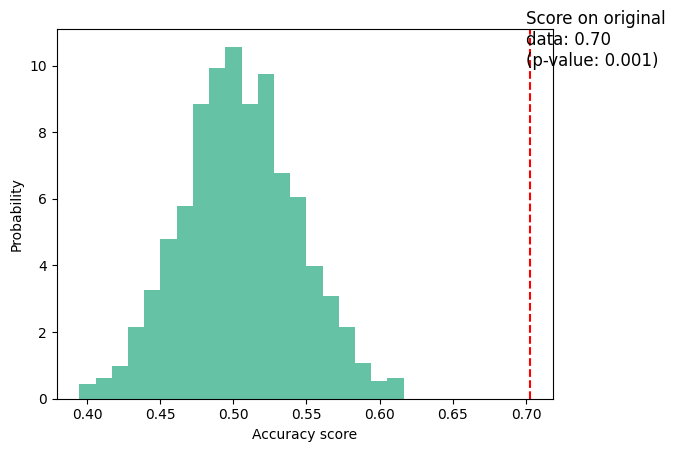

In [38]:
# permutation test

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = SVC(kernel="linear", random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X_thorax, y_thorax, scoring="accuracy", cv=cv, n_permutations=1000)

fig, ax = plt.subplots()

ax.hist(perm_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = f"Score on original\ndata: {score_iris:.2f}\n(p-value: {pvalue_iris:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")



In [25]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [26]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [27]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

<Axes: xlabel='param_clf', ylabel='value'>

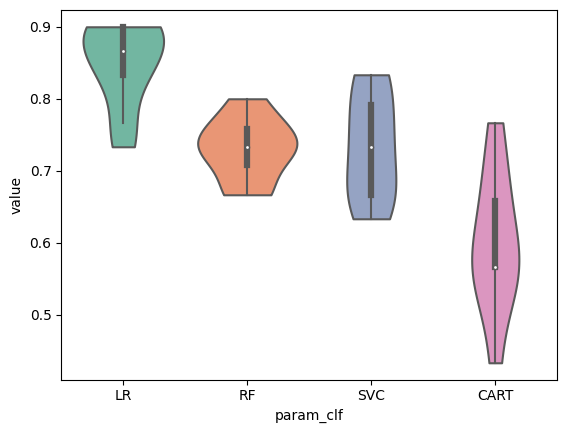

In [28]:
sn.violinplot(data=data_plot_head, x='param_clf',y='value', cut=0)

In [29]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train)

In [30]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9210526315789473
Accuracy on test set: 0.8648648648648649


In [31]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head

,precision,recall,f1-score,support
5w,0.960000,0.923077,0.941176,26.000000
7w,0.846154,0.916667,0.880000,12.000000
accuracy,0.921053,0.921053,0.921053,0.921053
macro avg,0.903077,0.919872,0.910588,38.000000
weighted avg,0.924049,0.921053,0.921858,38.000000


In [32]:
report_head.to_excel("../results/tables/accuracy_age_males_head.xlsx")

In [33]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax

,precision,recall,f1-score,support
5w,0.904762,0.863636,0.883721,22.000000
7w,0.812500,0.866667,0.838710,15.000000
accuracy,0.864865,0.864865,0.864865,0.864865
macro avg,0.858631,0.865152,0.861215,37.000000
weighted avg,0.867358,0.864865,0.865473,37.000000


In [34]:
report_thorax.to_excel("../results/tables/accuracy_age_males_thorax.xlsx")

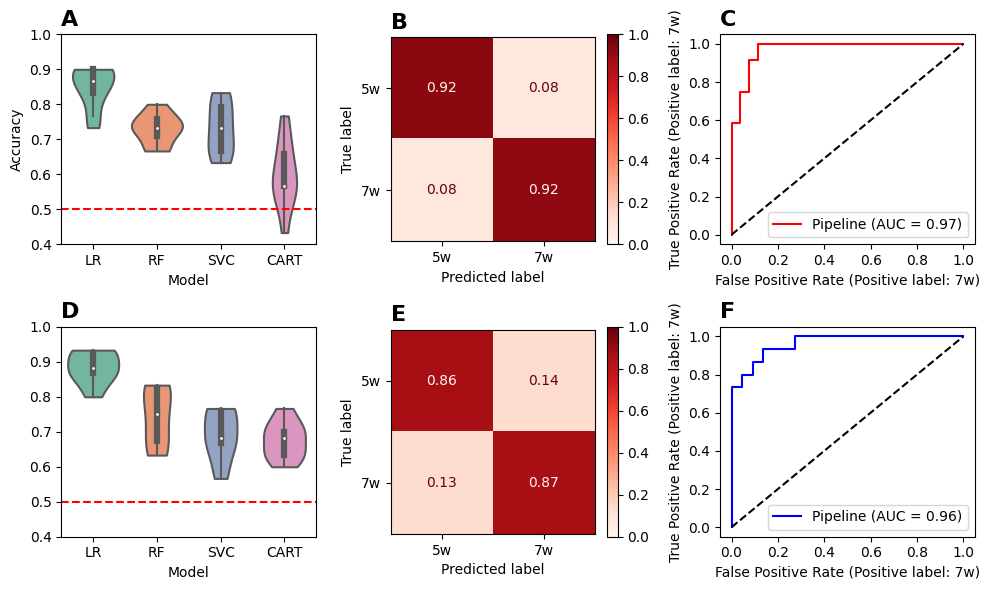

In [37]:
fig, ((ax,ax2, ax5),(ax3,ax4, ax6)) = plt.subplots(2,3,figsize=(10,6))
sn.violinplot(data=data_plot_head, x='param_clf',y='value',ax=ax, cut=0)
sn.violinplot(data=data_plot_thorax, x='param_clf', y='value', cut=0,ax=ax3)
ax.set_xlabel("Model")
ax.set_ylabel('Accuracy')
ax.set_ylim(0.4,1)
ax3.set_ylim(0.4,1)
ax.axhline(0.5, color='r',ls="--")
ax3.axhline(0.5, color='r',ls="--")
ax3.set_ylabel('')
ax3.set_xlabel("Model")


disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})



disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


RocCurveDisplay.from_estimator(pipe_head, X=X_hd_test, y=y_hd_test, ax=ax5, color='r')
ax5.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")

RocCurveDisplay.from_estimator(pipe_thorax, X=X_th_test, y=y_th_test, ax=ax6, color='b')
ax6.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")

sizeletters = 16
ax.set_title("A", loc='left', weight='bold',size=sizeletters)
ax2.set_title("B", loc='left', weight='bold', size=sizeletters)
ax3.set_title("D", loc='left', weight='bold', size=sizeletters)
ax4.set_title("E", loc='left', weight='bold', size=sizeletters)
ax5.set_title("C", loc='left', weight='bold', size=sizeletters)
ax6.set_title("F", loc='left', weight='bold', size=sizeletters)

plt.tight_layout()

plt.savefig("../results/plots/age_prediction_males.png", dpi=300)